In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

In [2]:
def preprocess_df(df):
    df['segs_out_diff'] = 0
    for i in range(1, len(df)):
        df.loc[i, 'segs_out_diff'] = df.loc[i, 'segs_out'] - df.loc[i-1, 'segs_out']
    df['inflight_hi_filled'] = df['inflight_hi'].ffill()
    df['inflight_lo_filled'] = df['inflight_lo'].fillna(0)
    if 'rwnd_limited' in df.columns:
        df['rwnd_limited_filled'] = df['rwnd_limited'].fillna('0ms').apply(lambda x: x[:-2]).astype(int)
    else:
        df['rwnd_limited_filled'] = 0


# iterate over df['phase'] and find out the segments for each phase. A phase can repeat, so take care of that. Store it in a dictionary which contains a list of segments where each segment contains start and end index.
def get_phase_segments(df):
    segments = {}
    curr_phase = 'STARTUP'
    phase_start = 0

    for i in range(1,len(df)):
        new_phase = df['phase'][i]
        if new_phase != curr_phase:
            if curr_phase not in segments:
                segments[curr_phase] = []
            segments[curr_phase].append((phase_start, i))
            curr_phase = new_phase
            phase_start = i
        else:
            continue

    # add the last segment
    if curr_phase not in segments:
        segments[curr_phase] = []
    segments[curr_phase].append((phase_start, len(df)))
    return segments


def plot(df, segments, title, adapt_ylim=False):
    lw = 1
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df['inflight_hi_filled'], color='orange', linewidth=lw, label='inflight_hi')
    ax.plot(df['inflight_lo_filled'], color='lime', linewidth=lw, label='inflight_lo')
    # ax.plot(df['cwnd'], color='blue', alpha=0.5)
    ax.plot(df['segs_out_diff'], color='blue', alpha=0.5, linewidth=lw, label='segs_out')
    ax.set_ylim(0, 4000)
    x_upper_lim = math.ceil(len(df)/3000) * 3000
    ax.set_xlim(0, x_upper_lim)
    ax.set_ylabel('Packets')
    ax.set_xlabel('Sampling interval (per 10ms)')
    for seg in segments['STARTUP']:
        ax.axvspan(seg[0], seg[1], facecolor='gray', alpha=0.2)
    # for seg in segments['PROBE_RTT']:
    #     ax.axvspan(seg[0], seg[1], facecolor='black', alpha=0.7)
    # for seg in segments['PROBE_BW_CRUISE']:
    #     ax.axvspan(seg[0], seg[1], facecolor='dodgerblue', alpha=0.3)
    # for seg in segments['PROBE_BW_UP']:
    #     ax.axvspan(seg[0], seg[1], facecolor='lavender')
    # for seg in segments['PROBE_BW_REFILL']:
    #     ax.axvspan(seg[0], seg[1], facecolor='red')

    ax2 = ax.twinx()
    ax2.plot(df['rwnd_limited_filled'], color='red', alpha=0.5, linewidth=lw, label='rwnd_limited')
    ax2.set_ylabel('rwnd_limited (ms)')
    rwin_upper_lim = math.ceil(df['rwnd_limited_filled'].max()/500)*500
    if adapt_ylim:
        ax2.set_ylim(0, rwin_upper_lim)
    else:
        ax2.set_ylim(0, 8000)

    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
    fig.suptitle(title, fontsize=14)

    fig.tight_layout()

    fig.savefig('./finalplots/' + title.replace(' ', '') + '.png', dpi=300)

In [3]:
paths = [
    r'',
    r'',
    r'',
    r'',
    r'',
    r'',
    r'',
    r'',
    r'',
    r'',
    r'',
    r''
]


titles = [
    'BBRv2 - RTT 100ms - Loss 0% - Time 5min',
    'BBRv2 - RTT 100ms - Loss 2% - Time 5min',
    'BBRv2 - RTT 100ms - Loss 2% - Time 5min - Adaptive inflight_hi 1000% Lthresh',
    'BBRv3 - RTT 100ms - Loss 0% - Time 5min',
    'BBRv3 - RTT 100ms - Loss 2% - Time 5min - Loss ct 6',
    'BBRv3 - RTT 100ms - Loss 2% - Time 5min - Loss ct 4',
    'BBRv3 - RTT 100ms - Loss 2% - Time 10min - Loss ct 8',
    'BBRv3 - RTT 100ms - Loss 2% - Time 5min - Adaptive inflight_hi',
    'BBRv3 - RTT 100ms - Loss 2% - Time 5min - Adaptive inflight_hi 1000% Lthresh',
    'BBRv3 - RTT 100ms - Loss 2% - Time 5min - Adaptive inflight_hi x2',
    'BBRv3 - RTT 100ms - Loss 2% - Time 5min - Sensitive start',
    'BBRv3 - RTT 100ms - Loss 2% - Time 5min - Sensitive start + Adaptive inflight_hi x2',
]

adapt_ylim_list = [
    False,
    False,
    True,
    False,
    False,
    False,
    False,
    False,
    True,
    False,
    False,
    False,
]

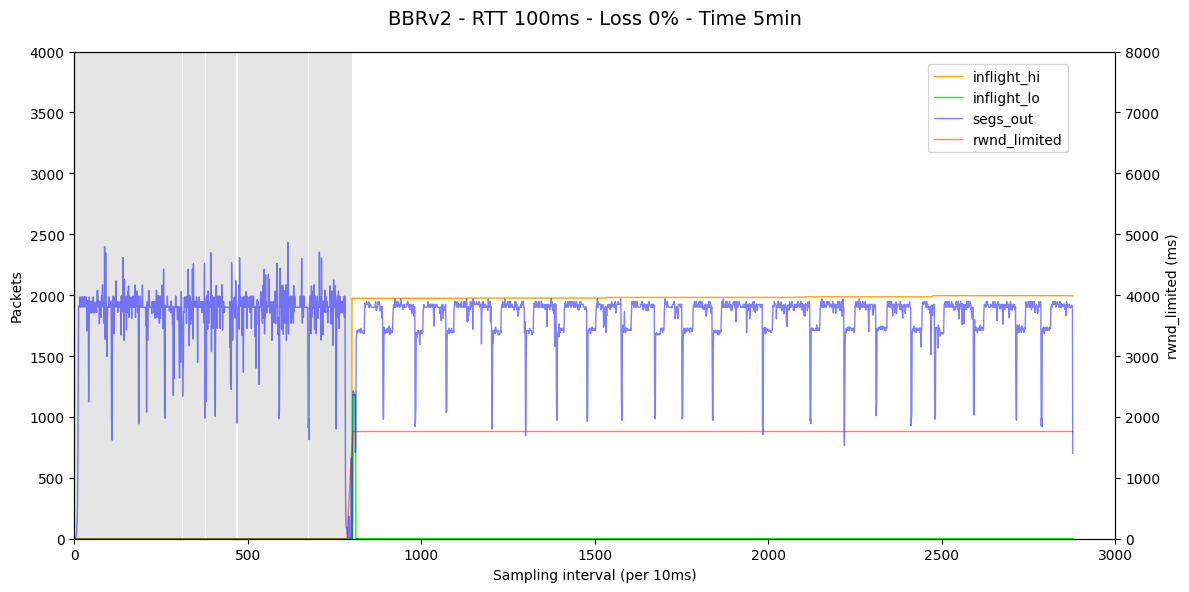

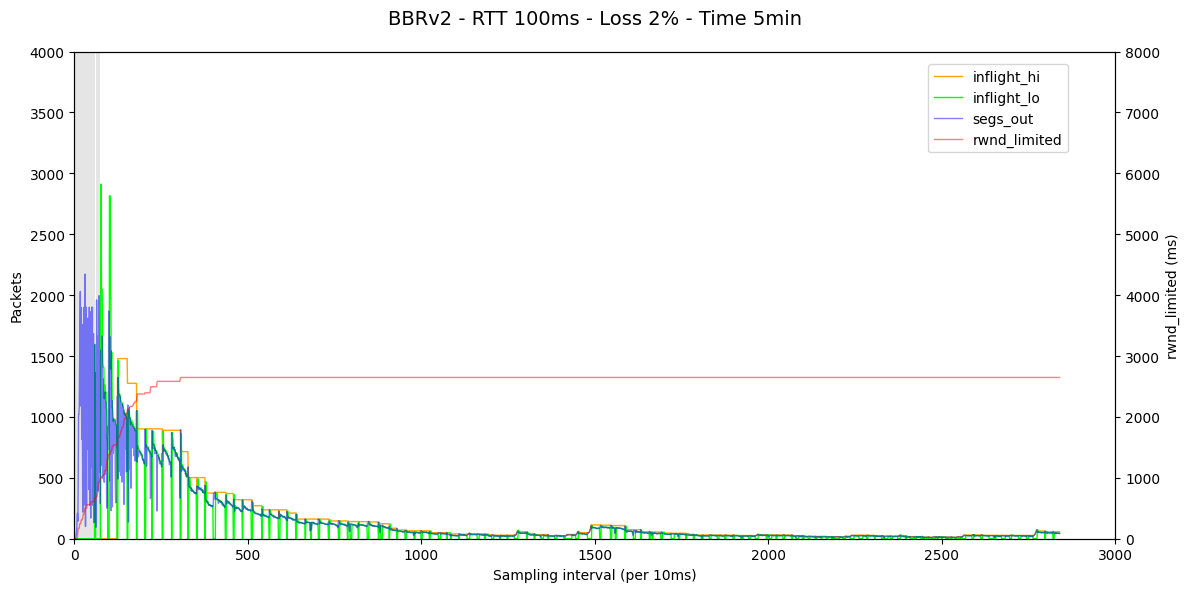

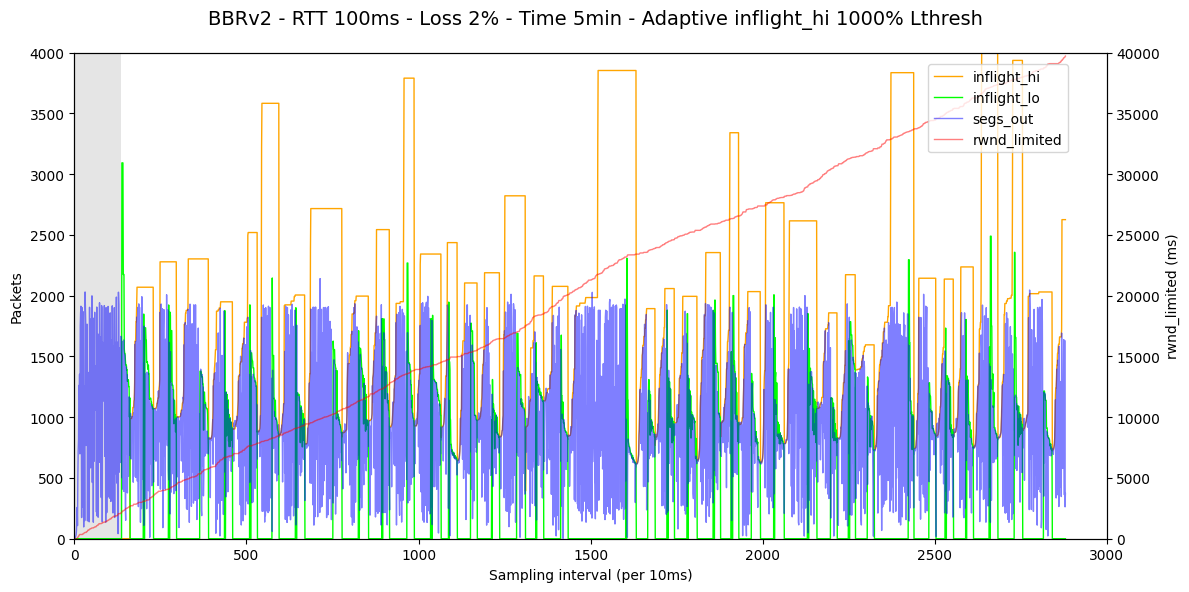

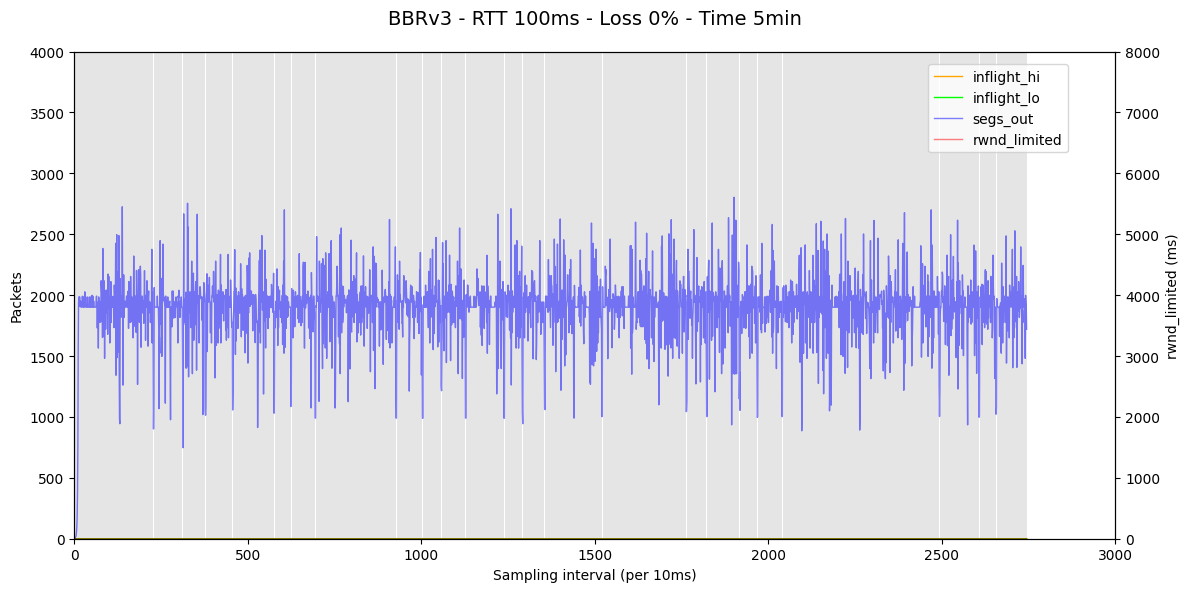

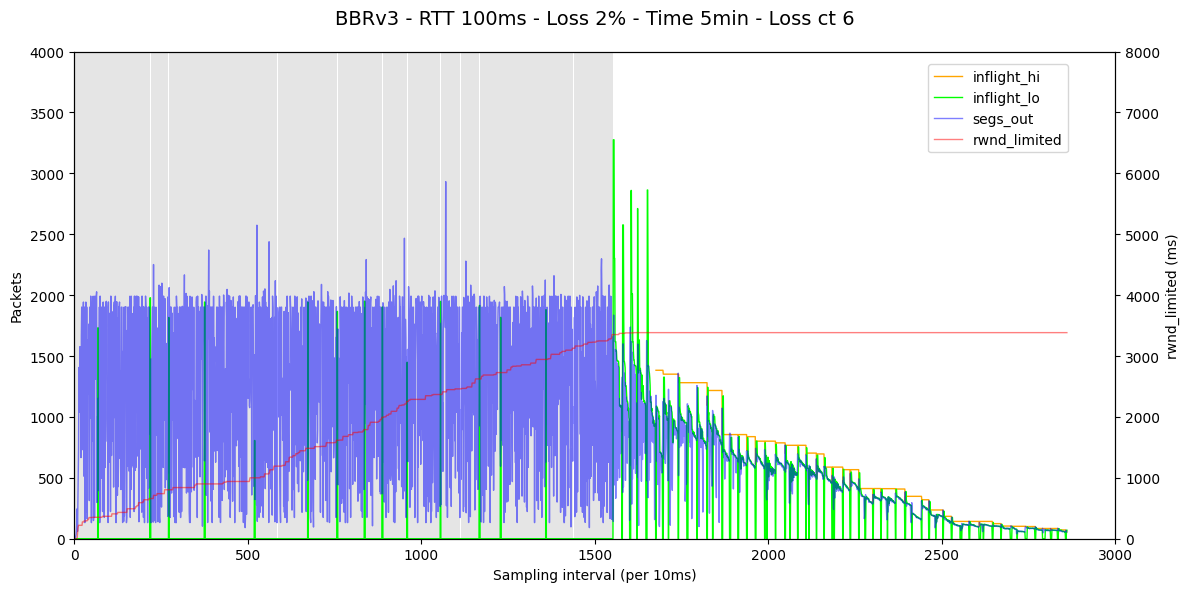

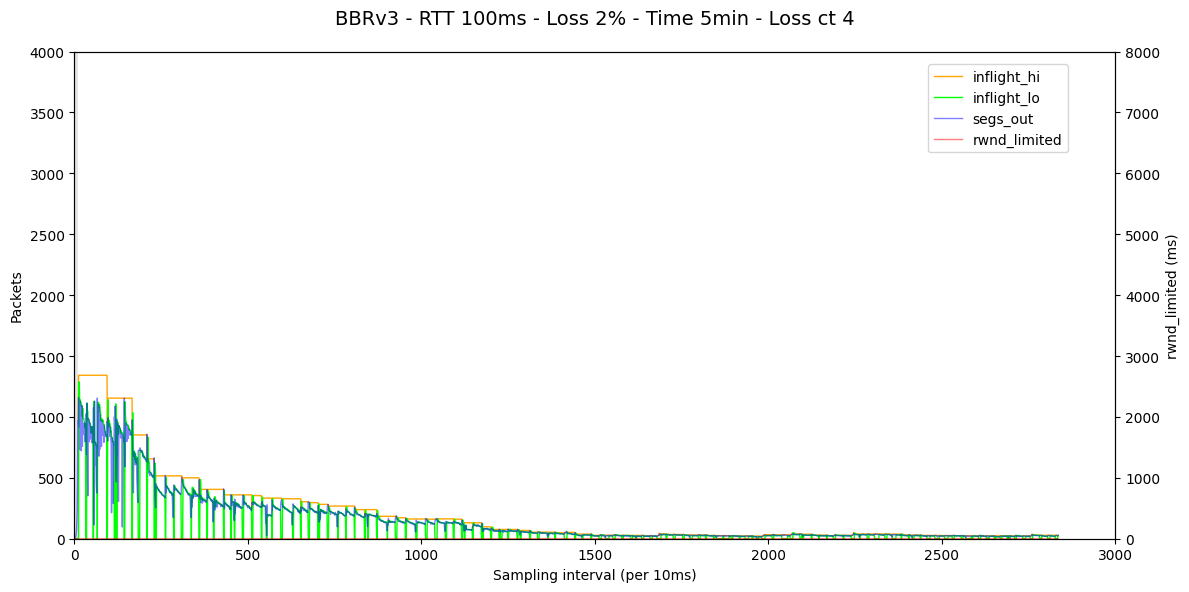

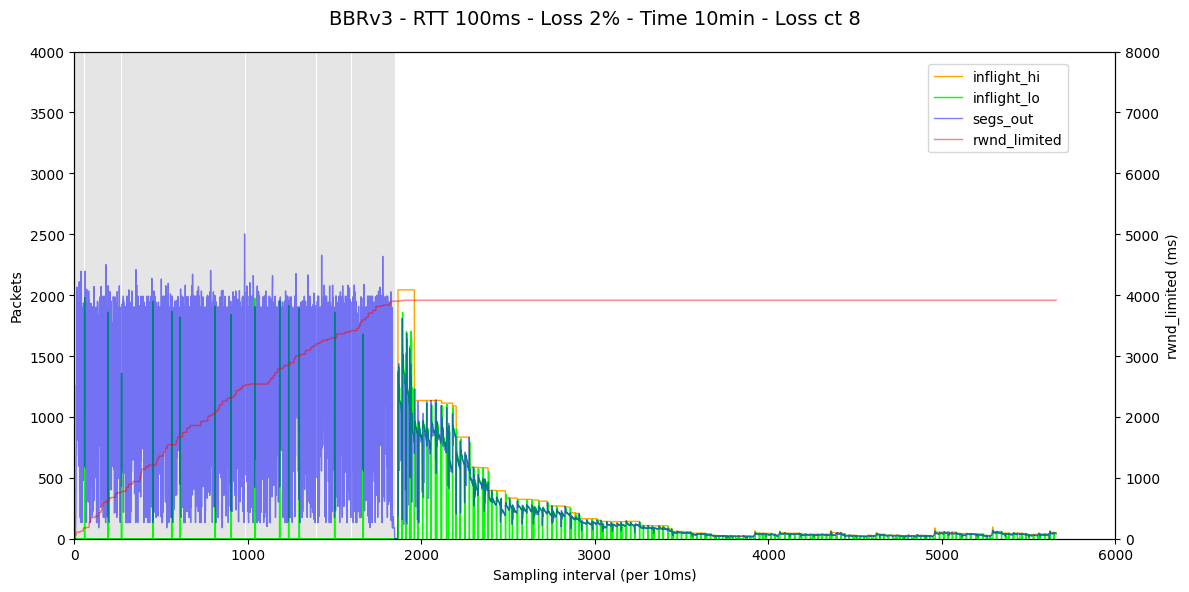

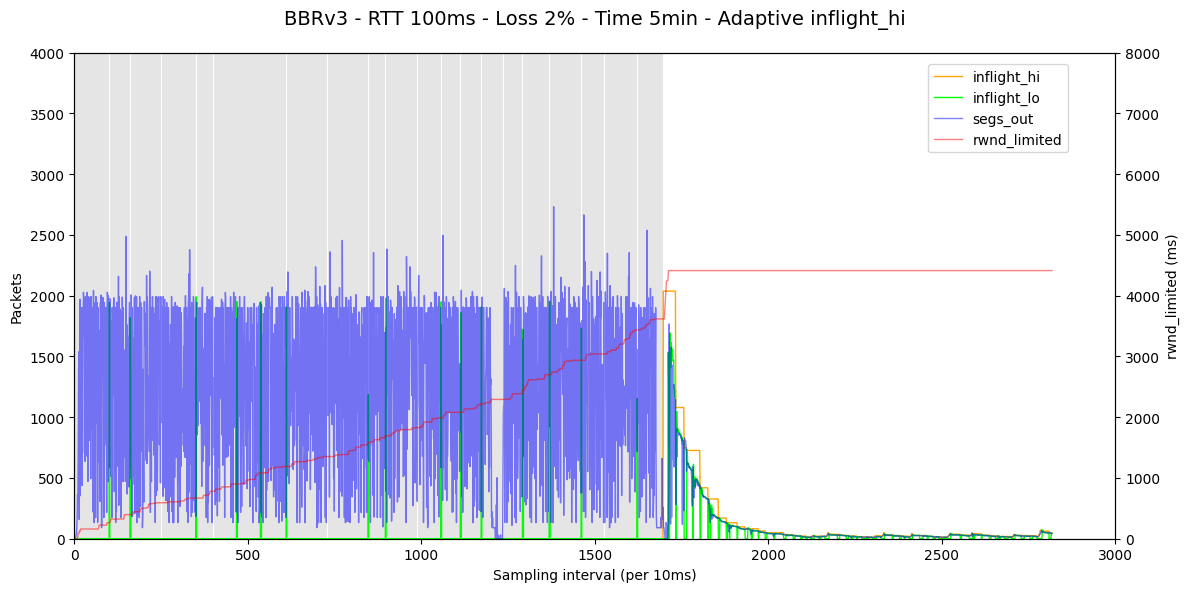

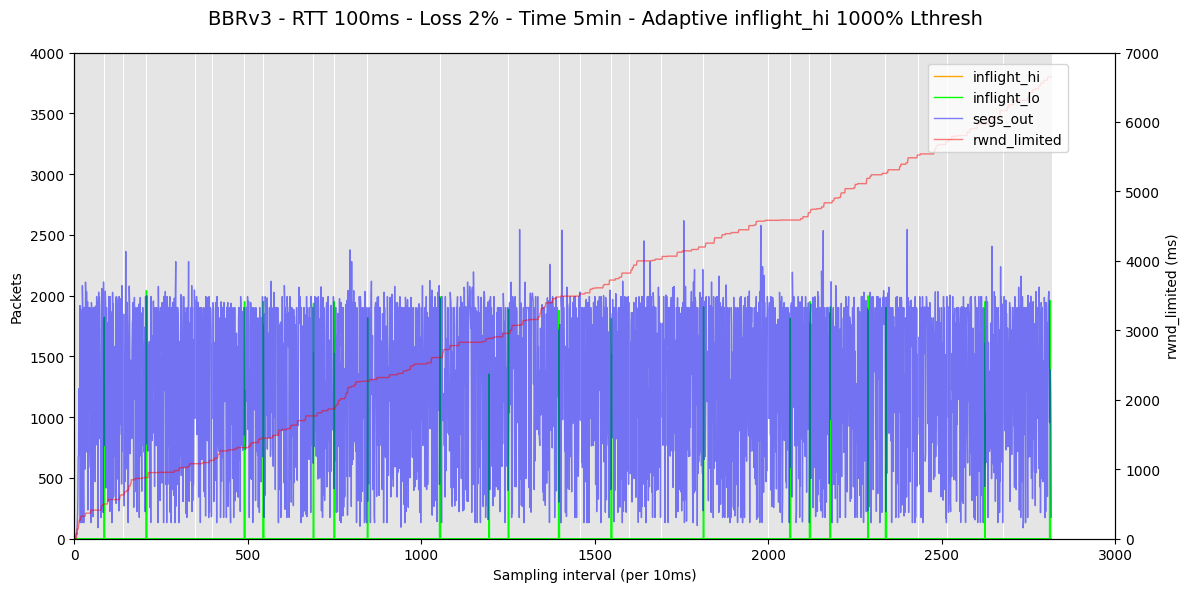

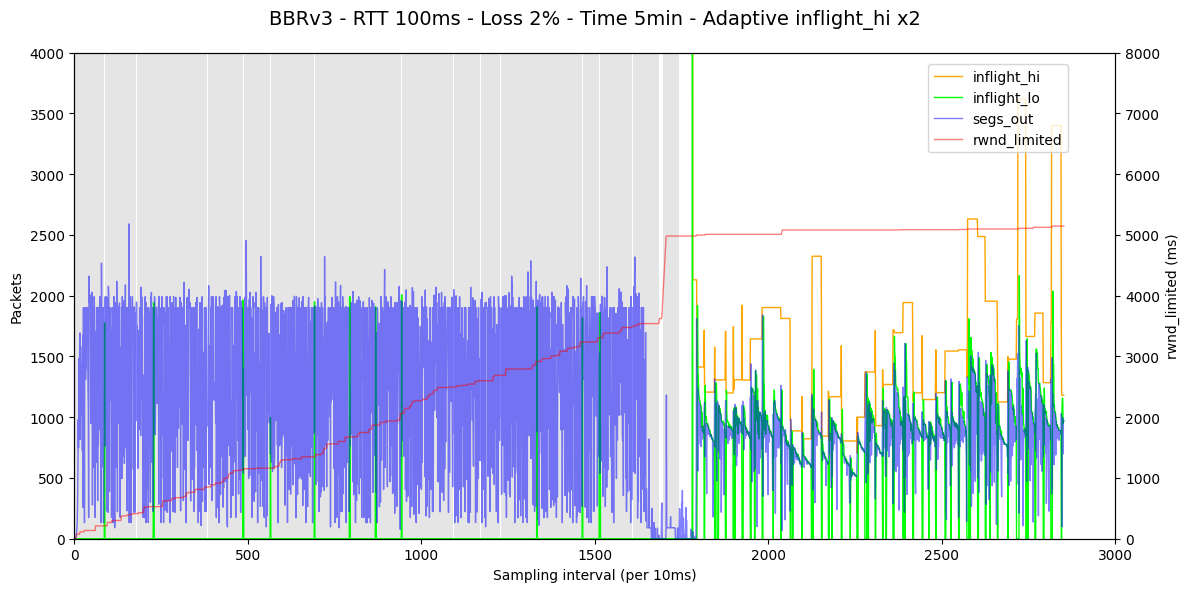

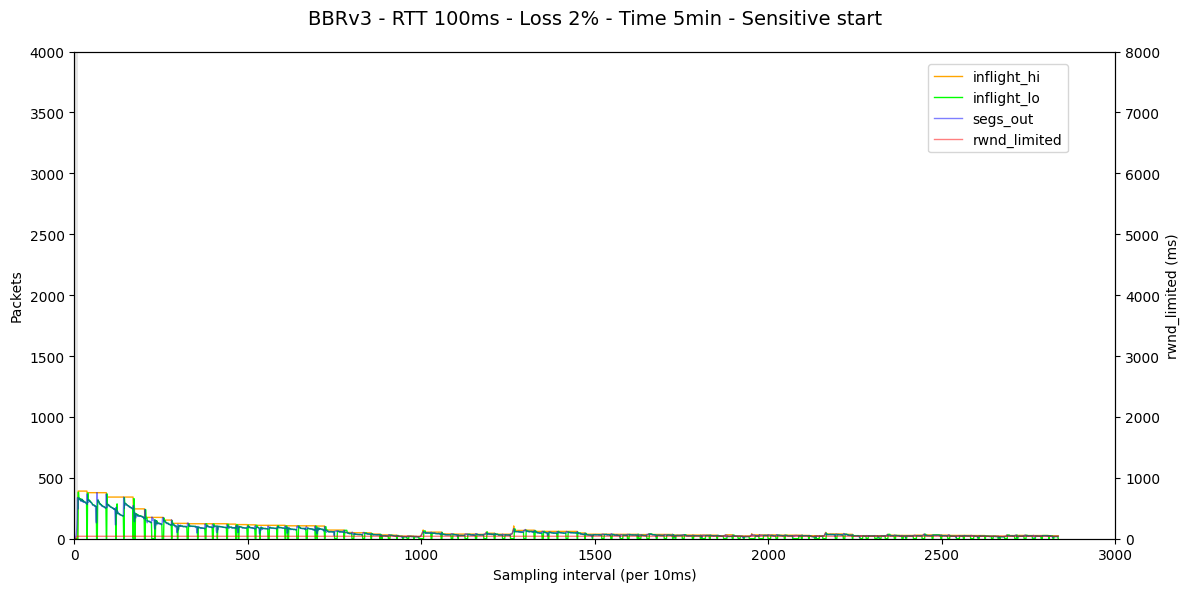

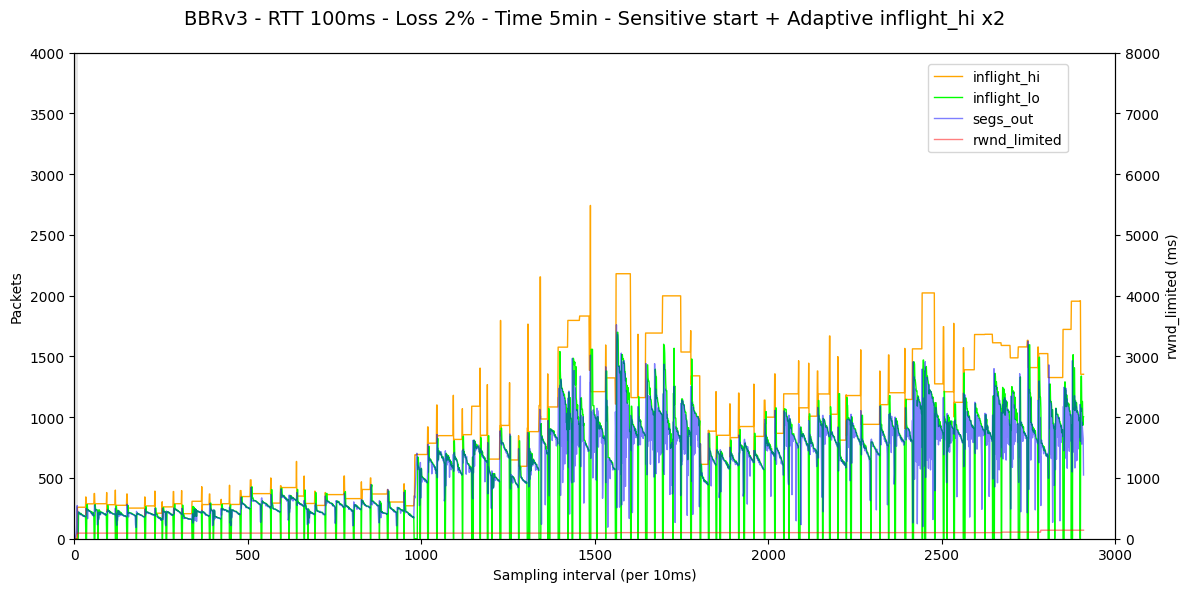

In [5]:
for path, title, adapt_ylim in zip(paths, titles, adapt_ylim_list):
    df = pd.read_csv(path)
    preprocess_df(df)
    segments = get_phase_segments(df)
    plot(df, segments, title, adapt_ylim=adapt_ylim)